# Assignment 3

This notebook is the solution to HW3, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [39]:
import nltk
from nltk import nonterminals, Nonterminal, Production
from nltk import CFG
from nltk import PCFG
from nltk.parse import generate
import itertools
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist
from nltk import Tree
from nltk.grammar import Production

Now after doing so we can go ahead and solve the tasks.

## Part 1

In the first part of the assignment we will discuss designing CFG for NLP task.
<br> We were given the following code which read CFGs from string representation, and parse sentences given a CFG using a  a bottom-up parsing algorithm:

In [4]:
sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


### Part 1.1

The first thing we would like to do is to extend the given CFG to support Number agreement, Pronouns and Dative Constructions

In [ ]:
sg = """
S -> NP VP
VP -> IV | TV NP | TV 
NP -> D N | NAME | D ADJ N |
D -> 'a'
NAME -> 'John' | 'Mary'
N -> 'bread' | 'boy' | 'book'
SPRO -> 'He' | 'She' | 'It' 
PPRO -> 'They' | 'Everybody'
APRO -> 'Him' | 'Her' | 'Them'
IV -> 'left'
TV -> 'eats' | 'loves' | 'gave'
TVP -> 'love' | 'eat'
ADJ -> 'heavy' | 'white'
P -> 'to' 
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

## Part 2

NLTK has a model called generate which is able to generate sentences given a CFG grammer. 
Our goal in this part is to create a generator for a PCFG instead of a CFG.

### Part 2.1

We will firstly start by writing our generator function, which, given a PCFG, return a tree representing the generation process:

In [179]:
# generates a tree from a PCFG grammer 
def pcfg_generate(grammar):
    start = grammar.start()
    return(pcfg_generate_root(grammar, start))
    
# generates a tree from a given root based on the PCFG grammer    
def pcfg_generate_root(grammar, root):
    #if it's not a terminal it means we have to generate from the probabilities
    if isinstance(root, Nonterminal):
        item_productions = grammar.productions(lhs=root)
        dict = {}
        for pr in item_productions: dict[pr.rhs()] = pr.prob()
        item_probDist = DictionaryProbDist(dict)
        prod = item_probDist.generate()
        if (len(prod) == 2):
            lh = prod[0]
            rh = prod[1]
            lh_tree = pcfg_generate_root(grammar, lh)
            rh_tree = pcfg_generate_root(grammar, rh)
            return Tree(root, [lh_tree, rh_tree])
        else:
            lh = prod[0]
            return Tree(root,[pcfg_generate_root(grammar, lh)])
           
    #if it's a terminal we can just return it
    else:
        return root

Now we can test our function with the *toy_pcfg2* grammer:

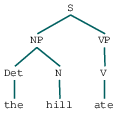

(S (NP (Det the) (N hill)) (VP (V ate)))
         S      
      ___|____   
     NP       VP
  ___|___     |  
Det      N    V 
 |       |    |  
the     hill ate



In [187]:
example_tree = pcfg_generate(toy_pcfg2)
import IPython
IPython.core.display.display(example_tree)
example_tree.pprint()
Tree.fromstring(example_tree.pformat()).pretty_print()

As we can see, not all the resulting sentences makes sense... 

We will now continue on to do some validations:

#### Part 2.1.1

The first thing we are going to do is to generate 1000 random trees given the *toy_pcfg2* grammer, and save all resulting trees into a file called "toy_pcfg2.gen"

In [195]:
def create_trees_file(n=1000):
    for i in range(n):
        current_tree = pcfg_generate(toy_pcfg2)
        with open("toy_pcfg2.gen", "a+") as f:
            current_tree.pprint(stream=f)
            f.write("*")

In [196]:
create_trees_file(n=1000)

In [214]:
read_file = open("toy_pcfg2.gen", "r")
buffer = ""
for line in read_file :
    buffer += line
trees = buffer.split("*")
trees = trees[:len(trees) - 1]

In [217]:
from nltk import induce_pcfg
productions = []
for tree in trees:
    productions += Tree.fromstring(tree).productions()
induce_pcfg(Nonterminal('S'), productions).productions()

[S -> NP VP [1.0],
 NP -> NP PP [0.306984],
 NP -> Name [0.274248],
 Name -> 'Bob' [0.458886],
 PP -> P NP [1.0],
 P -> 'under' [0.397013],
 NP -> Det N [0.418768],
 Det -> 'the' [0.40938],
 N -> 'hill' [0.49971],
 VP -> V NP [0.582505],
 V -> 'ran' [0.275],
 Det -> 'a' [0.313839],
 N -> 'table' [0.115808],
 P -> 'with' [0.602987],
 Name -> 'Jack' [0.541114],
 Det -> 'my' [0.276781],
 VP -> V [0.411531],
 V -> 'ate' [0.509],
 N -> 'boy' [0.112913],
 N -> 'telescope' [0.143023],
 N -> 'cookie' [0.128547],
 V -> 'saw' [0.216],
 VP -> VP PP [0.00596421]]